In [142]:
from transformers import pipeline, set_seed

### Hugging face tutorial

In [143]:
generator = pipeline('text-generation', model='gpt2')

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [144]:
generator('Harry looked into the stands. Colin was sitting on a stool', max_length=100, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Harry looked into the stands. Colin was sitting on a stool and looking up at her. He took the seat next to him as he stared at Yang. She looked a bit apprehensive as she stared at him, but he ignored her. "You look like you might be getting it." She said in an annoyed manner. "Look at how you look. How you look like you\'re going to have to work harder, right?"\n\n"It\'s okay. I\'m done with fighting you'},
 {'generated_text': 'Harry looked into the stands. Colin was sitting on a stool in front of a group of students. She looked up at him. He looked at Colin in a sad tone, the sort of angry face he usually wore whenever asked what would happen. He nodded. Colin picked up the bowl of cereal of his favourite breakfast cereal and sat up. He quickly took the cups off the desk and ate.\n\nAt the end of the night, Colin took a sip of one of the coffee that had come'},
 {'generated_text': "Harry looked into the stands. Colin was sitting on a stool in a large closet, stari

### fastai experiment

In [9]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import torch
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [7]:
text = 'Tripping on hallucinogenics'
encoded_input = tokenizer.encode(text)
encoded_input

[14824, 2105, 319, 23251, 259, 6644, 873]

In [8]:
tokenizer.decode(encoded_input)

'Tripping on hallucinogenics'

In [10]:
t1 = torch.LongTensor(encoded_input)[None]
preds = model.generate(t1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [11]:
preds

tensor([[14824,  2105,   319, 23251,   259,  6644,   873,   318,   257,  2219,
          3357,   287,   262,  1578,  1829,    13,   198,   198,   464,  2563]])

In [12]:
tokenizer.decode(preds[0])

'Tripping on hallucinogenics is a common practice in the United States.\n\nThe drug'

### integrate with fastai

In [13]:
from fastai.text.all import *

In [40]:
def get_text_data():
    pth = Path('../data')
    files = get_text_files(pth).sorted()
    txt = [f.open(encoding='gb18030').read() for f in files]
    return txt

In [138]:
txt = get_text_data()

In [34]:
pth = Path('../data')/'harry potter4.txt'
pth

Path('../data/harry potter4.txt')

In [44]:
tokenizer.tokenize(txt[0][:100]),txt[0][:100]

(['--------------------',
  '---',
  'ĠPage',
  'Ġ1',
  '--------------------',
  '---',
  'ĊĊ',
  'Ġ',
  'Ġ',
  'ĠThe',
  'ĠCome',
  'plete',
  'ĠHarry',
  'ĠPotter',
  'ĠCollection',
  'Ġ',
  'Ġ',
  'Ċ',
  'Ġ',
  'Ċ'],
 '----------------------- Page 1-----------------------\n\n   The Comeplete Harry Potter Collection  \n \n')

In [49]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(
            self.tokenizer.convert_tokens_to_ids(toks)
        )
    
    def decodes(self,x):
        return TitledStr(self.tokenizer.decode(x.cpu()))

- in encodes we don't use the tokenizer.encode method since it does some additional preprocessing for the model after tokenizing and numericalizing (the part throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
- in decodes we return a TitledStr object and not just a plain string. That's a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods.

In [46]:
toks = tokenizer.tokenize(txt[0][:100])
t1 = tensor(tokenizer.convert_tokens_to_ids(toks))
t1

tensor([19351,  6329,  7873,   352, 19351,  6329,   628,   220,   220,   383,
         7911,  6677,  5850, 14179, 12251,   220,   220,   198,   220,   198])

In [76]:
len(txt)

7

### fastai data

In [50]:
path = untar_data(URLs.WIKITEXT_TINY)

In [52]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])

In [64]:
splits = [[0,1,2,3,4],[5,6]]
tls = TfmdLists(txt, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [78]:
len(tls.train),len(tls.valid)

(5, 2)

In [80]:
len(tls.train[0])

149901

In [81]:
bs = 4
sl = 256
dls = tls.dataloaders(bs=4, seq_len=sl)

In [83]:
x,y = first(dls.train)

In [85]:
x.shape,y.shape

(torch.Size([4, 256]), torch.Size([4, 256]))

In [ ]:
dls.show_batch(max_n=2)

In [88]:
class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

In [91]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[accuracy, Perplexity()]).to_fp16()

In [92]:
learn.validate()

(#3) [3.6438446044921875,0.3942023813724518,38.23856735229492]

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

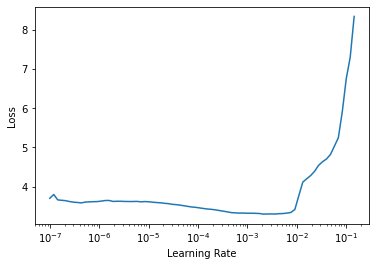

In [93]:
learn.lr_find()

In [94]:
learn.fit_one_cycle(1, 3e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.624687,4.227454,0.371931,68.542511,53:41


In [155]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.443017,4.227674,0.379385,68.557587,1:15:12


In [97]:
x[0][200:300]

LMTensorText([ 3114,   329,  1223,   220,   220,   198,  5562,   561,  1037,   683,
         3551,   465, 14268,    11,   366,    54,  2007, 21460,   287,   262,
         6675, 20283,   220,   220,   198, 19085,  1601,  8920, 13248,   306,
         6252,  1203,  2112,   526,   220,   220,   198,   220,   198,   464,
          627,   359, 24487,   379,   262,  1353,   286,   257,  1884,    12,
        11534,  7322,    13,  5850,   350,  7474], device='cuda:0')

In [99]:
tokenizer.decode(x[0][200:300])

' looked for something  \nthat would help him write his essay, "Witch Burning in the Fourteenth  \nCentury Was Completely Pointless discuss."  \n \nThe quill paused at the top of a likely-looking paragraph. Harry Pushed'

In [156]:
txt = 'Harry, what is wrong with you?'
ids = tokenizer.encode(txt)
inp = tensor(ids)[None].cuda()

In [157]:
preds = learn.model.generate(inp, max_length=100)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [158]:
tokenizer.decode(preds[0].cpu())

"Harry, what is wrong with you?''I'm not going to tell you,' said Harry, 'I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I"

In [131]:
preds[0][200:]

tensor([11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 

In [141]:
num_t = 0
for t in txt:
    num_t += len(t)
    print(len(t))

486827
544314
675372
1240897
1499118
1209375
1377391


In [142]:
num_t

7033294

## 03-16

In [2]:
from fastai.text.all import *
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

In [78]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [7]:
path = Path('../data')
path.ls()

(#7) [Path('../data/harry potter4.txt'),Path('../data/harry potter3.txt'),Path('../data/harry potter5.txt'),Path('../data/harry potter2.txt'),Path('../data/harry potter1.txt'),Path('../data/harry potter6.txt'),Path('../data/harry potter7.txt')]

In [11]:
file_pths = path.ls().sorted()
file_pths

(#7) [Path('../data/harry potter1.txt'),Path('../data/harry potter2.txt'),Path('../data/harry potter3.txt'),Path('../data/harry potter4.txt'),Path('../data/harry potter5.txt'),Path('../data/harry potter6.txt'),Path('../data/harry potter7.txt')]

In [40]:
def read_text_in_file(pth):
    arr = []
    with open(pth,encoding='gb18030') as f:
        line = f.readline()
        while(line):
            arr+=[line]
            line = f.readline()
    return arr

In [105]:
def clean_text_data(book):
    book = [t for t in book if len(t.strip()) > 0]
    book = [t for t in book if '-------' not in t]
    return book

def count_n_of_txt(arr):
    c = 0
    for t in arr:
        c += len(t.strip())
    return c

In [106]:
books = [read_text_in_file(pth) for pth in file_pths]

In [107]:
books = [clean_text_data(b) for b in books]

In [108]:
[count_n_of_txt(b) for b in books]

[430682, 480511, 597809, 1112238, 1481980, 1065305, 1189193]

In [167]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
#     def encodes(self, x):
#         toks = self.tokenizer.tokenize(x)
#         return tensor(
#             self.tokenizer.convert_tokens_to_ids(toks)
#         )
    
    def decodes(self,x):
        return TitledStr(self.tokenizer.decode(x.cpu()))


class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

In [145]:
data =sum(books[:],[])

In [146]:
pct = math.floor(len(data)*0.9)
pct

76535

In [147]:
splits = [range(0,pct), range(pct, len(data) - 1)]
tokenized = [tokenize(t) for t in data]
tls = TfmdLists(data, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=8,seq_len=256)

In [148]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[accuracy, Perplexity()]).to_fp16()

In [171]:
learn.validate()

(#3) [2.636012077331543,0.5089584589004517,13.95743179321289]

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

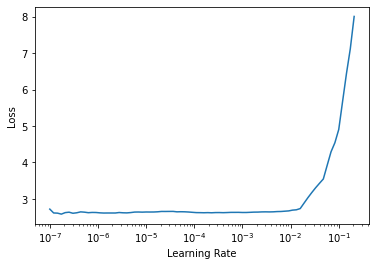

In [172]:
learn.lr_find()

In [151]:
learn.freeze()
learn.fit_one_cycle(1,2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.879858,2.636012,0.508958,13.957432,02:50


In [ ]:
learn.
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time


In [137]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-6,5e-5))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.507210,2.906039,0.461389,18.284235,00:26


In [173]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-5/(2.6**4), 1e-5))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.609533,2.644010,0.509904,14.069513,02:54


In [168]:
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 256 x 768       
Embedding                                 38597376   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 2304      
Conv1D                                    1771776    True      
Conv1D                                    590592     True      
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 256 x 3072      
Conv1D                                    23623

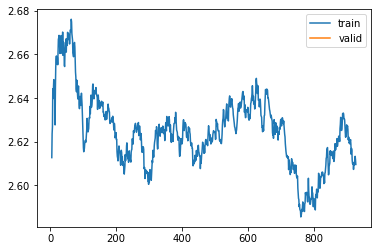

In [175]:
learn.recorder.plot_loss()

In [184]:
txt = 'She had opened the last envelope, and yellowish-green liquid smelling strongly of'
ids = tokenizer.encode(txt)
inp = tensor(ids)[None].cuda()
preds = learn.model.generate(inp, max_length=150,num_beams=5, 
#     num_return_sequences=5,
#     no_repeat_ngram_size=2,
#     repetition_penalty=1.5,
#     top_p=0.92,
    temperature=.85,
#     do_sample=True,
#     top_k=125,
#     early_stopping=True
                            )
print(preds.shape, tokenizer.decode(preds[0].cpu()))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([1, 150]) She had opened the last envelope, and yellowish-green liquid smelling strongly of  
                                                                                                                                   


In [155]:
x, y = dls.train.one_batch()
x.shape

torch.Size([8, 256])

In [156]:
tokenizer.decode(x[0][:200])

'toward a witch who was clearly shrieking in agony - "feel the Dementor\'s \n         "Bugged?" said Ron blankly.         "What... put fleas on her or something?"  \nlamp,   stood   a   boy   Harry   recognized   at   once:   tall,   pale,   dark-haired,   and \n         She had opened the last envelope, and yellowish-green liquid smelling strongly of  \nwhich meant that the promising Gryffindor team Harry had been training so \nThey left the stadium right away... He was furious they\'d come onto the  \npockets, looking almost wistfully at the train.  \nwhole head swung off his neck and fell onto his shoulder as if it was on'